 # Notebook para detecção de quebra de diálogo

In [14]:
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors

## Bases de desenvolvimento e teste

In [32]:
base_path = 'C:/Users/landrade/Dropbox/python/dbdc3/'
#base_path = 'C:/Users/Leonardo de Andrade/Dropbox/python/dbdc3/'
dev_data_path = pathjoin(base_path,'data/dbdc3/en/crf_baseline/train')
eval_data_path = pathjoin(base_path,'data/dbdc3/en/crf_baseline/test')
output_data_path = pathjoin(base_path, 'data/dbdc3/en/experimento_v2_out/')
wikpediaW2Vec = pathjoin(base_path,'wikpedia_embeddings/model.txt')

In [3]:
def separateEval(originPath, destinationPath, count):
    files = listdir(originPath)
    eval_files = numpy.random.choice(files,count,False)
    if not os.path.exists(destinationPath):
        os.makedirs(destinationPath)
    for file in eval_files:
        os.rename(pathjoin(originPath,file),pathjoin(destinationPath,file))

## Separando 30% em arquivos de teste

In [7]:
# Comentando para não correr o risco de rodar novamente
#separateEval(cic_dev_path,cic_eval_path,34)
#separateEval(iris_dev_path,iris_eval_path,30)
#separateEval(tktk_dev_path,tktk_eval_path,30)
#separateEval(yi_dev_path,yi_eval_path,30)

### Funções úteis

In [4]:
def loadConversations(path):
    conversations = []
    for f in listdir(path):
        if '.log.json' in f:
            json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
            json_obj['file_name'] = f
            conversations.append(json_obj)
    return conversations

In [5]:
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations
        

In [6]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [7]:
def printHistogram(data,name):
    print('O = not a breakdown, T = possible breakdown, and X = breakdown')
    dataSum = ConversationClassCount(data)
    plt.hist(list(dataSum.keys()), weights=list(dataSum.values()))
    plt.title(name)
    plt.show()

In [190]:
def saveJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName.replace('.log.json','.labels.json'))
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [191]:
def outputFiles(outputPath, pipeline, test):
    test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    data = {}
    data['turns'] = []
    size = test.shape[0]
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        predictedValue = pipeline.predict(test.iloc[[i]])
        predictedProba = pipeline.predict_proba(test.iloc[[i]])
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue[0]
        label['prob-O'] = predictedProba[0][0]
        label['prob-T'] = predictedProba[0][1]
        label['prob-X'] = predictedProba[0][2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            saveJson(outputPath, test.iloc[i]['file_name'], data)
            data = {}
            data['turns'] = []
            
        
outputFiles(output_data_path,pipeline, test)

## Carregando Word2vec

In [40]:
w2v = KeyedVectors.load_word2vec_format(wikpediaW2Vec)

In [79]:
def Document2Vec(text,w2v):
    tokens = text.split()
    tokens = [word.lower() for word in tokens if (word.lower() in w2v.vocab)]
    count = 0
    vector = np.array([0]*w2v.vector_size)
    for word in tokens:
        vector = vector + w2v[word]
        count = count + 1
    if count ==0:
        count =1
    return vector / count

## Computando distribuição e voto majoritário

In [8]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations(dev_data_path),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations(eval_data_path),0)

## Histograma de cada conjunto

In [4]:
#printHistogram(cic_data,'CIC')
#printHistogram(iris_data,'IRIS')
#printHistogram(tktk_data,'TKTK')
#printHistogram(yi_data,'YI')

## Montando o conjunto

In [9]:
def PrepareDataSet(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = c['turns'][i]['utterance']
                line['system-index'] = c['turns'][i+1]['turn-index']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [200]:
def PrepareDataSetWithTail(conversations, w2v):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                line['user-utterance-tail'] = userTurnTail
                line['system-utterance-tail'] = systemTurnTail
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

## Transformers

In [130]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [182]:
from sklearn.base import BaseEstimator, TransformerMixin
class W2VecSelector(BaseEstimator, TransformerMixin):
    def __init__(self, w2v):
        self.w2v = w2v

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return [Document2Vec(text,self.w2v) for text in X]

In [132]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [212]:
from scipy import sparse

class EmbeddingVectorizer(BaseEstimator):
    def _init_(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True,binary=False):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        self.binary      = binary;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        #this arrays says if a word in the vocab has 
        self.missingWord_  = np.zeros(len(self.vect.vocabulary_),dtype=np.int8);
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            if temp.sum() == 0 :
                self.missingWord_[index] = 1;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        M = sparse.csc_matrix(self.missingWord_).T;
        
        missing = (X>0).dot(M)/(X>0).sum(axis=1);
        missing = sparse.csc_matrix(missing.reshape(-1,1));
        
        #memory friendly dot product
        X  = X.dot(V)/X.sum(axis=1);
        
        #last columns will contain the embedding coverage
        X = sparse.hstack([X,missing]);
        
        return X;
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [133]:
import numpy as np
class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))

## Monta o dataset

In [203]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev,w2v))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test,w2v))

In [205]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2910 entries, 0 to 2909
Data columns (total 12 columns):
O                        2910 non-null float64
T                        2910 non-null float64
X                        2910 non-null float64
class                    2910 non-null object
dialogue-id              2910 non-null object
file_name                2910 non-null object
system-index             2910 non-null int64
system-utterance         2910 non-null object
system-utterance-tail    2910 non-null object
user-index               2910 non-null int64
user-utterance           2910 non-null object
user-utterance-tail      2910 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 272.9+ KB


In [213]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                ('selector', ItemSelector(key='user-utterance-tail'))
                ,('W2VecSelector', W2VecSelector(w2v))
            ])),
            
            ('system-utterance-vector', Pipeline([
                ('selector', ItemSelector(key='system-utterance-tail'))
                ,('W2VecSelector', W2VecSelector(w2v))
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
            
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(kernel='linear', probability=True)),
])

In [209]:
pipeline.fit(train, train['class'])

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user-utterance', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='user-utterance')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [93]:
xpto = pipeline.predict_proba(test.iloc[[1]])
#xpto[0][2]
#pipeline.predict(test.iloc[[1]])
test.iloc[1].file_name

'CIC0009.log.json'

In [211]:
y = pipeline.predict(test)
print(classification_report(y, test['class']))

             precision    recall  f1-score   support

          O       0.59      0.59      0.59       426
          T       0.34      0.44      0.39       232
          X       0.66      0.58      0.62       582

avg / total       0.58      0.56      0.56      1240



In [30]:
y = pipeline.predict(test)
print(classification_report(y, test['class']))

             precision    recall  f1-score   support

          O       0.59      0.58      0.59       437
          T       0.30      0.42      0.35       214
          X       0.65      0.56      0.60       589

avg / total       0.57      0.54      0.55      1240



(array([358., 336., 222., 160.,  39.,  18.,  13.,   1.,   1.,   2.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

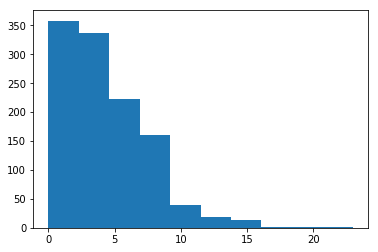

In [70]:
plt.hist( (  CountVectorizer().fit_transform(train['user-utterance']) >0 ).sum(axis=1))

(array([669., 238., 143.,  47.,  25.,  13.,   5.,   5.,   3.,   2.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

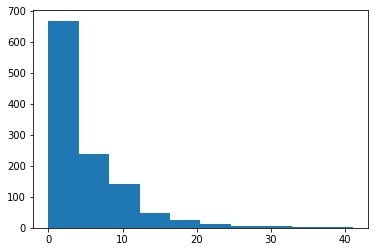

In [71]:
plt.hist( (  CountVectorizer(binary=True).fit_transform(train['system-utterance']) >0 ).sum(axis=1))

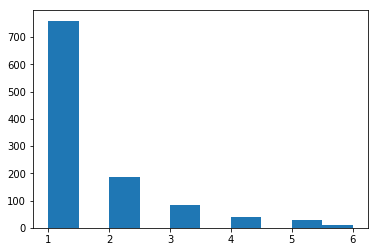

In [78]:
plt.hist(np.array(CountVectorizer(binary=True,max_df=6).fit_transform(train['user-utterance']).sum(axis=0))[0]);